# 1. Word Importance Model for Predicting Importance of Words in Captions
 
     Paper Title: A Corpus for Modeling Word Importance in Spoken Dialogue Transcripts
        https://arxiv.org/pdf/1801.09746.pdf

    Corpus: The Switchboard corpus consists of audio recordings of approximately 260 hours of speech consisting of about 2,400 two-sided telephone conversations among 543 speakers (302 male, 241 female) from across the United States. In January 2003, the Institute for Signal and Information Processing (ISIP) released written transcripts for the entire corpus, which consists of nearly 400,000 conversational turns. The ISIP transcripts include a complete lexicon list and automatic word alignment timing corresponding to the original audio files
    
    The importance score ranges from 0 to 1. However, the paper, referred above, have categorized the words based on the importance level as follows:
        
    Importance Distribution:
    Importance 1: [0-0.1) 
    Importance 2: [0.1-0.3) 
    Importance 3: [0.3-0.5) 
    Importance 4: [0.5-0.7) 
    Importance 5: [0.7-0.9) 
    Importance 6: [0.9-1] 

    The higher the imporance value is, the higher the weight of the word.

    Unsupervised Learning Approaches:
    1. Bag-of-Words
    2. Term frequency and Inverse Document Frequency
    3. Word Embedding(CBOW) Summerization with interpolation of POS importance
    4. Composition of Contextualized Word Embedding (BERT)
    
    Supervised Learning Approaches:
    Note: Contextualized Word Embeddings (BERT) as feature
    1. Logistic Regression
    2. Random Forest Classifier
    
    Existing Best Performing Prior Work:
    Neural Network-based approach(LSTM)

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Word\ Importance\ using\ Word-Embedding/Code/


/content/drive/My Drive/Word Importance using Word-Embedding/Code


# 2. Importing Libraries

In [3]:
!pip3 install gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip3 install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip3 install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [6]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import string
import numpy as np
import random
import heapq
import gensim
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

# Load pre-trained model's tokenizer (BERT vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [9]:
# Variable Definition
folder = {
    '20':['2005'],
    '21':['2191'],
    '22':['2222'],
    '23':['2348'],
    '24':['2450'],
    '25':['2565'],
    '26':['2636'],
    '27':['2710'],
    '28':['2886'],
    '30':['3044','3083'],
    '32':['3203'],
    '33':['3301','3324'],
    '36':['3601'],
    '38':['3817'],
    '40':['4010','4021'],
    '43':['4320'],
    '44':['4400'],
    '45':['4531'],
    '47':['4721']
}

file_type = ['A','B']
size_of_bow = 100
threshold = 0.4

alpha = 5

wem_vector_size = 50

POS_IMPORTANCE = {'NN':3.95,'NNP':3.95,'NNS':3.95,
                  'VB':3.82, 'VBZ':3.82,'VBP':3.82,
                  'VBG':3.82,'VBD':3.82,'VBN':3.82,
                  'JJ':3.80,'RB':3.43 }

CV = 5

In [10]:
def make_scalar(Y, typ = 0):
    y_all =[]
    for y in Y:
        
        if typ == 0:
            if 0 <= float(y) < 0.1:
                y_all.append(1);
            elif 0.1 <=  float(y) < 0.3:
                y_all.append(2);
            elif 0.3 <=  float(y) < 0.5:
                y_all.append(3);
            elif 0.5 <= float(y) < 0.7:
                y_all.append(4);
            elif 0.7 <= float(y) < 0.9:
                y_all.append(5);
            else:
                y_all.append(6);
        else:
            y_all.append(y)
    return y_all

def make_confusion_matrices(Y_pred, Y_gold, typ):
    Y_pred = make_scalar(Y_pred, typ)
    Y_gold = make_scalar(Y_gold, typ)
    cm = confusion_matrix(Y_pred, Y_gold)
    return cm

# 3. Bag of Words Model
Measuring word importance using bag of words model. If a token appear in BOW, that will be annotated as `1` or highly important. Otherwise, the token will be weighted as `0`. We consider a variable `threshold` to define the boundary between important and less important words.

We have applied certain Modification of Bag of words approach. We know that in Bag of Words approach, create a one-hot vector for each word would be approapriate. But given the requirement of the problem, we have assgined cumulative importance score for each word which is assigned following the method discussed above.

# 3.1 Text Preprocessing
At this step, we have processed raw transcript files to extract tokens and word importance annotated files to extract annotated word to score mapping. Since the importance score was annotated for each word individually, it was recommended not to remove stopwords from the corpora. There is a possibility that in conversational text, a good amount of words can be excluded if we remove stopwords in pre-processing pipeline. By removing punctuation and other special characters, we have normalized the text. In this process, I have extracted lemma of the words to define the tokens. 

In [11]:
# Text Preprocessor
 # Prcessing the text: to extract the text and corresponding sense from each line of the file
def process_text(line):
    splitLine = line.split(" ")
    return splitLine[-1].replace("\n","")

def process_wimp(line):
    splitLine = line.split(" ")
    last_word = splitLine[-1].replace("\n","")
    splitLine[-1] =  last_word
    return splitLine

In [12]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], '')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text
def normalize_text(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = convert_numbers(data)
    data = lemmatizing(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = remove_punctuation(data) 
    return data

In [13]:
# Read words from the switchboard word list
def get_words_list(file_name):
    files = open(file_name)
    text = ""
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        text = text + actual_sentence
    
    return text

In [14]:
# Read words from the switchboard word list
def get_words_list_from_sentence(sentence):
    sentence = sentence.split(" ")
    return sentence


In [15]:
def get_word_freq(file):
    corpus = get_words_list(file)
    wordfreq = {}
    tokens = nltk.word_tokenize(str(corpus))
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
    return wordfreq

In [16]:
def make_bag_of_words(file):
    wordfreq = get_word_freq(file)
    most_freq = heapq.nlargest(size_of_bow, wordfreq, key=wordfreq.get)
    return most_freq

In [17]:
def get_sentence_list(file_name):
    files = open(file_name)
    sentence_set=[]
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        sentence_set.append(actual_sentence.replace("\n",""))
    return sentence_set

In [18]:
def get_word_importance(file):
    corpus = get_sentence_list(file)
    sentence_vectors = []
    most_freq = make_bag_of_words(file)
    for sentence in corpus:
        sentence = normalize_text(sentence)
#         print(sentence)
        sentence_tokens = nltk.word_tokenize(str(sentence))
        sent_vec = []
        for token in sentence_tokens:
            if token in most_freq:
                sent_vec.append(1)
            else:
                sent_vec.append(0)

        sentence_vectors.append(sent_vec)
#     print(sentence_vectors)
    return sentence_vectors

# 3.2 Performance Measure


In [19]:
def get_wimp_scores(file_name ):
    files = open(file_name)
    scores = []
    for sentence in files.readlines():
        score_array = process_wimp(sentence) 
        scores.append(score_array[3:])

    return scores

In [ ]:
BOW_MSE = 0
BOW_Accuracy = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
          # /content/drive/My\ Drive/
            # file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            # wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            bow = get_word_importance(file)
            scores = get_wimp_scores(wimp_file)

            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(bow[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    for j in range(0,len(scores[i])):

                        if (float(bow[i][j])>threshold and float(scores[i][j])>threshold) or (float(bow[i][j])<=threshold and float(scores[i][j])<=threshold):
                            correct = correct +1
                            BOW_MSE = BOW_MSE + pow(float(bow[i][j])-float(threshold),2)


            accuracy = correct/total
            BOW_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(BOW_Accuracy))+"/44: Accuracy "+ str(accuracy))
        

Document Processed- 1/44: Accuracy 0.17378640776699028
Document Processed- 2/44: Accuracy 0.21851851851851853
Document Processed- 3/44: Accuracy 0.22713864306784662
Document Processed- 4/44: Accuracy 0.18508092892329345
Document Processed- 5/44: Accuracy 0.14345991561181434
Document Processed- 6/44: Accuracy 0.1634182908545727
Document Processed- 7/44: Accuracy 0.2249488752556237
Document Processed- 8/44: Accuracy 0.251434034416826
Document Processed- 9/44: Accuracy 0.23314917127071824
Document Processed- 10/44: Accuracy 0.1902834008097166
Document Processed- 11/44: Accuracy 0.22535211267605634
Document Processed- 12/44: Accuracy 0.2568493150684932
Document Processed- 13/44: Accuracy 0.18274111675126903
Document Processed- 14/44: Accuracy 0.2767857142857143
Document Processed- 15/44: Accuracy 0.25901639344262295
Document Processed- 16/44: Accuracy 0.2837465564738292
Document Processed- 17/44: Accuracy 0.21161825726141079
Document Processed- 18/44: Accuracy 0.2403846153846154
Document P

# 4. TF-IDF Implementation
The idea behind the TF-IDF approach is that the words that are more common in one sentence and less common in other sentences should be given high weights.

In [20]:
def measure_idf(file):
    word_idf_values = {}
    most_freq = make_bag_of_words(file)
    corpus = get_sentence_list(file)
    for token in most_freq:
        doc_containing_word = 0
        for document in corpus:
            if token in nltk.word_tokenize(document):
                doc_containing_word += 1
        word_idf_values[token] = np.log(len(corpus)/(1 + doc_containing_word))
#     print(word_idf_values)
    return word_idf_values

In [21]:
def measure_tf_score(file):
    word_tf_values = {}
    corpus = get_sentence_list(file)
    most_freq = make_bag_of_words(file)
    for token in most_freq:
        sent_tf_vector = []
        for document in corpus:
            doc_freq = 0
            for word in nltk.word_tokenize(document):
                if token == word:
                      doc_freq += 1

            word_tf = doc_freq/len(nltk.word_tokenize(document))
            sent_tf_vector.append(word_tf)
        word_tf_values[token] = sent_tf_vector
    return word_tf_values

In [22]:
def measure_tf_idf_score(file):
    word_tf_values = measure_tf_score(file)
    word_idf_values =  measure_idf(file)
    tfidf_values = []
    for token in word_tf_values.keys():
        tfidf_sentences = []
        for tf_sentence in word_tf_values[token]:
            tf_idf_score = tf_sentence * word_idf_values[token]
            tfidf_sentences.append(tf_idf_score)
        tfidf_values.append(tfidf_sentences)
    return tfidf_values

In [23]:
def get_tf_idf_word_importance(file):
    corpus = get_sentence_list(file)
    sentence_vectors = []
    word_tf_values = measure_tf_score(file)
    word_idf_values = measure_idf(file)
    count = 0 
    for sentence in corpus:
        sentence = normalize_text(sentence)
        sentence_tokens = nltk.word_tokenize(str(sentence))
        sent_vec = []
        for token in sentence_tokens:
            if token in word_tf_values:
                sent_vec.append(word_tf_values[token][count]*word_idf_values[token])
            else:
                sent_vec.append(0)
        
        sentence_vectors.append(sent_vec)
        count=count+1
    return sentence_vectors

# 4.1 Performance Measure


In [24]:
def compare(X, Y):
    if (0 <= X < 0.1 and 0 <= Y < 0.1) or (0.1 <= X < 0.3 and 0.1 <= Y < 0.3) or (0.3 <= X < 0.5 and 0.3 <= Y < 0.5) or (0.5 <= X < 0.7 and 0.5 <= Y < 0.7) or (0.7 <= X < 0.9 and 0.7 <= Y < 0.9) or (0.9 <= X <=1 and 0.9 <= Y <= 1):
        return True
    else: 
        return False

In [25]:
def get_wimp_scores(file_name ):
    files = open(file_name)
    scores = []
    for sentence in files.readlines():
        score_array = process_wimp(sentence) 
        scores.append(score_array[3:])

    return scores

In [26]:
def NormalizeTfIdfData(data):
#     print("data::",data)
    min_v = 0.01
    max_v = 0
    for sentence_score in data:
        for words_score in sentence_score:
                min_v = min(min_v, words_score)
                max_v = max(max_v, words_score)
    
    data[:] = [(np.array(x)-min_v)/(max_v-min_v) if len(x)>1 else [0] for x in data]
        
    return data

In [ ]:
TF_IDF_MSE = 0
TF_IDF_Accuracy = []
Y_gold_tf = [] 
Y_pred_tf = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            # file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            # wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            sent_vector = get_tf_idf_word_importance(file)
            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0
            sent_vector = NormalizeTfIdfData(sent_vector)
            for i in range(0,len(scores)):
                if len(sent_vector[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_tf += make_scalar(scores[i], 0)
                    Y_pred_tf += make_scalar(sent_vector[i], 0)
                    for j in range(0,len(scores[i])):
                        
                        if compare(float(sent_vector[i][j]), float(scores[i][j])):
                            correct = correct +1
                            TF_IDF_MSE = TF_IDF_MSE + pow((float(sent_vector[i][j])-float(scores[i][j])),2)
            accuracy = correct/total
            TF_IDF_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(TF_IDF_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("SE:" +str(TF_IDF_MSE))

NameError: ignored

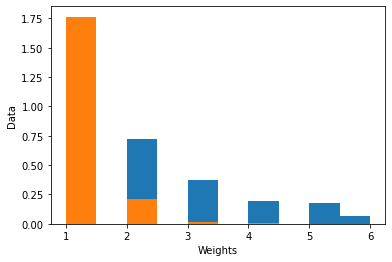

In [ ]:
plt.hist(Y_gold_tf, density=True, bins=10)  # density=False would make counts


plt.hist(Y_pred_tf, density=True, bins=10)  # density=False would make counts
plt.ylabel('Data')
plt.xlabel('Weights');

In [ ]:
print(classification_report(Y_gold_tf,Y_pred_tf))
print("Accuracy: %.2f"%accuracy_score(Y_gold_tf, Y_pred_tf))
cm = make_confusion_matrices(Y_gold_tf, Y_pred_tf, 1)
cm

              precision    recall  f1-score   support

           1       0.23      0.88      0.36      5955
           2       0.41      0.12      0.19      9461
           3       0.22      0.01      0.02      4926
           4       0.05      0.00      0.00      2571
           5       0.00      0.00      0.00      2360
           6       0.00      0.00      0.00       869

    accuracy                           0.25     26142
   macro avg       0.15      0.17      0.10     26142
weighted avg       0.25      0.25      0.15     26142

Accuracy: 0.25


array([[5265,  592,   64,   19,    9,    6],
       [8196, 1135,   95,   27,    4,    4],
       [4254,  603,   51,   11,    6,    1],
       [2358,  196,   12,    3,    1,    1],
       [2176,  172,    7,    3,    0,    2],
       [ 810,   56,    3,    0,    0,    0]])

# 5. Incorporating POS with Word Embedding in generating Word Importance 
The training algorithm that has been used to define the word vector is Continuous Bag of Words(CBOW).

Importance of various POS is subjective and depends on the application as well as the domain under consideration, it can be very useful to evaluate their importance even in a general setup. In this paper(http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.599.3242), researchers present a study to understand this importance. 

We have used 1st step of Neural Bag-of-word2. 

Composition(Summarizing word vectors) of word embedding may refer to semantic or syntactic meaning.


# 5.1 Building Word-Embedding using Word2Vec 


In [27]:
def build_vocabulary(all_words):
    word2vec = Word2Vec(all_words, min_count=2, size= wem_vector_size, workers=3, window = 10)
    vocabulary = word2vec.wv.vocab
    WV=np.zeros(shape=(len(vocabulary),wem_vector_size))
    count=0
    for voc in vocabulary.keys():
        WV[count] = word2vec.wv[voc]
        count = count + 1
    return (word2vec,vocabulary)


In [28]:
def build_pos_imp(vocabulary, all_words, pos_tagged):
    POS_IMP={}
    count=0
    for voc in vocabulary.keys():
        if voc in all_words[0]:
            for sent_pos in pos_tagged:
                for word, pos in sent_pos:
                    if word == voc:
                        POS_IMP[voc] = POS_IMPORTANCE.get(pos,2.5)
                        break
        else:
            POS_IMP[voc] = 2.5

        count=count+1
    return POS_IMP

In [29]:
def build_word_matrix(vocabulary, all_words, POS_IMP,word2vec):
    BOW=np.zeros(shape=(len(all_words),1))
    WV=np.zeros(shape=(len(all_words),wem_vector_size))
    POSA = np.zeros(shape=(len(all_words),1))
    count=0
    for word in all_words:
        if word in  vocabulary.keys():
            BOW[count] = [1.0]
            WV[count] = word2vec.wv[word]
            POSA[count] = [POS_IMP[word]]
        else:
            BOW[count] = [0]
        count=count+1

    return (BOW, WV, POSA)

In [30]:
def NormalizeData(data):
#     print("data::",data)
    min_v = 0.01
    max_v = 0
    for sentence_score in data:
        for words_score in sentence_score:
                min_v = min(min_v, words_score)
                max_v = max(max_v, words_score)
    data = [(x-min_v)/(max_v-min_v) if len(x)>1 else [0] for x in data]
        
    return data


# 5.2 Performance Measure

In [ ]:
WEM_MSE = 0
WEM_Accuracy = []
Y_gold_wm = [] 
Y_pred_wm = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"

            
            corpus = get_sentence_list(file)

            all_words = [normalize_text(sent) for sent in corpus]
            pos_tagged = []
            for i in range(len(all_words)):
                all_words[i] = [w for w in word_tokenize(str(all_words[i]))]
                pos_tagged.append(pos_tag(all_words[i]))

            word2vec,vocabulary = build_vocabulary(all_words)
            WIMP = []
            for sentence in all_words:
                POS_IMP = build_pos_imp(vocabulary, sentence, pos_tagged)

                BOW, WV, POSA = build_word_matrix(vocabulary, sentence, POS_IMP, word2vec)
                A = BOW * WV * POSA
                WIMP_TEMP=[]
                for i in range(0,len(sentence)):
                    WIMP_TEMP.append(np.mean(A[i]))
                    WIMP.append(WIMP_TEMP)

            WIMP = NormalizeData(WIMP)
            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(WIMP[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_wm += make_scalar(scores[i], 0)
                    Y_pred_wm += make_scalar(WIMP[i], 0)
                    for j in range(0,len(scores[i])):
                        if compare(float(WIMP[i][j]), float(scores[i][j])):
                            correct = correct +1
                            WEM_MSE = WEM_MSE + pow((float(WIMP[i][j])-float(scores[i][j])),2)

            accuracy = correct/total
            WEM_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(WEM_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("MSE: ", str(WEM_MSE))
       

Document Processed- 1/44: Accuracy 0.25
Document Processed- 2/44: Accuracy 0.33
Document Processed- 3/44: Accuracy 0.30
Document Processed- 4/44: Accuracy 0.75
Document Processed- 5/44: Accuracy 0.34
Document Processed- 6/44: Accuracy 1.00
Document Processed- 7/44: Accuracy 0.69
Document Processed- 8/44: Accuracy 0.36
Document Processed- 9/44: Accuracy 0.44
Document Processed- 10/44: Accuracy 0.18
Document Processed- 11/44: Accuracy 0.46
Document Processed- 12/44: Accuracy 0.53
Document Processed- 13/44: Accuracy 0.11
Document Processed- 14/44: Accuracy 0.23
Document Processed- 15/44: Accuracy 0.10
Document Processed- 16/44: Accuracy 0.14
Document Processed- 17/44: Accuracy 0.40
Document Processed- 18/44: Accuracy 0.44
Document Processed- 19/44: Accuracy 0.24
Document Processed- 20/44: Accuracy 0.10
Document Processed- 21/44: Accuracy 0.36
Document Processed- 22/44: Accuracy 1.00
Document Processed- 23/44: Accuracy 0.14
Document Processed- 24/44: Accuracy 0.53
Document Processed- 25/44

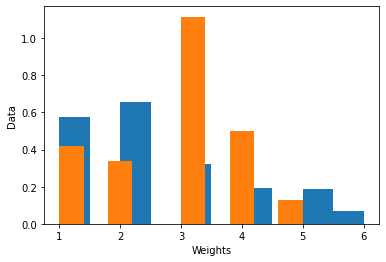

In [ ]:
plt.hist(Y_gold_wm, density=True, bins=10)  # density=False would make counts
plt.hist(Y_pred_wm, density=True, bins=10)

plt.ylabel('Data')
plt.xlabel('Weights');

In [ ]:
print(classification_report(Y_gold_wm,Y_pred_wm))
print("Accuracy: %.2f"%accuracy_score(Y_gold_wm, Y_pred_wm))
cm = make_confusion_matrices(Y_gold_wm, Y_pred_wm, 1)
cm

              precision    recall  f1-score   support

           1       0.77      0.45      0.57       328
           2       0.47      0.19      0.27       375
           3       0.20      0.55      0.29       184
           4       0.09      0.19      0.12       111
           5       0.16      0.08      0.11       106
           6       0.00      0.00      0.00        41

    accuracy                           0.31      1145
   macro avg       0.28      0.25      0.23      1145
weighted avg       0.43      0.31      0.32      1145

Accuracy: 0.31


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[147,  28,  92,  49,  12,   0],
       [ 33,  73, 163,  86,  20,   0],
       [  6,  24, 102,  41,  11,   0],
       [  2,  15,  67,  21,   6,   0],
       [  4,  11,  55,  27,   9,   0],
       [  0,   5,  32,   4,   0,   0]])

# 6. Context-aware Term Weight Determination Using BERT

Prior work has shown that these embeddings can characterize a token’s syntactic features (e.g., word dependencies) and semantic features (e.g., named entity labeling), which can help estimate a term’s importance. Here, the contextualized token embeddings have been fed into a linear layer. It maps a token’s embedding into a real-number weight.

http://www.cs.cmu.edu/~zhuyund/Zhuyun_Dai_Dissertation.pdf

https://www.cs.cmu.edu/~callan/Papers/TheWebConf20-Zhuyun-Dai.pdf


In [31]:
# Loading pre-trained BERT Base
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)

#Use evaluation mode
model.eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [32]:
def BERT_Embedding(text):
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize text
    tokenized_text = tokenizer.tokenize(marked_text)
    # print("Text:" + str(len(text.split())))
    # print("Length of tokenized text: " + str(len(tokenized_text)))

    # print("Actual Text:", text)
    # print("Tokenized Text", tokenized_text)

    # Map tokenized text to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

        # `output_hidden_states = True` so the 3rd element has the hidden states for each layer. 
        # More information at: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs_sum = []
    # `token_embeddings` is a [32 x 12 x 768] tensor, now for each token of 32:

    for token in token_embeddings:

        # `token` is a [12 x 768] tensor
        # Sum the vectors from the last four layers to represent the token.
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    BERT_Word_Embedding = np.zeros(shape=(len(token_vecs_sum),len(token_vecs_sum[0])))
    for i in range(0, len(token_vecs_sum)):
        BERT_Word_Embedding[i] = token_vecs_sum[i].numpy()
#     print(BERT_Word_Embedding.shape)
    return (BERT_Word_Embedding, tokenized_text)



# 6.1 Performance Measure

In [ ]:
from IPython.core.display import Math
BERT_Accuracy = []
Y_gold_bert = []
Y_pred_bert = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
           
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            corpus = get_sentence_list(file)

            all_words = [str(normalize_text(sent)) for sent in corpus]
            
    
            contextual_wimp_data=[]
            for text in all_words:
                sentence_mat, tokenized_text = BERT_Embedding(text)

                WIMP_temp = []

                index = 1
                count = 1

                for word_emb in sentence_mat[1:-1]:
                    

                    word_emb = np.reshape(word_emb,(word_emb.size,1))

                    W = np.ones(shape=(len(word_emb),1))

                    X = np.dot(W.T,word_emb)

                    # New index
                    if tokenized_text[index].startswith("##"):
                      WIMP_temp[-1] =  WIMP_temp[-1] + X[0][0]
                      count = count + 1
                    else:
                      if len(WIMP_temp) > 0:
                        WIMP_temp[-1] = WIMP_temp[-1]/count
                      WIMP_temp.append(X[0][0])
                      count = 1
                    ###########
                    
                    # New index
                    index = index + 1
                    
                    
                contextual_wimp_data.append(WIMP_temp)

            contextual_wimp_data = NormalizeData(contextual_wimp_data)

            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0

            for i in range(0,len(scores)):
                # print(str(len(contextual_wimp_data[i]))+" "+str(len(scores[i])))
                if len(contextual_wimp_data[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_bert += make_scalar(scores[i], 0)
                    Y_pred_bert += make_scalar(contextual_wimp_data[i], 0)
                    for j in range(0,len(scores[i])):
                        if compare(float(contextual_wimp_data[i][j]), float(scores[i][j])):
                            correct = correct +1

            accuracy = correct/total
            BERT_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(BERT_Accuracy))+"/44: Accuracy %.2f"%accuracy)

            
    

Document Processed- 1/44: Accuracy 0.11
Document Processed- 2/44: Accuracy 0.19
Document Processed- 3/44: Accuracy 0.37
Document Processed- 4/44: Accuracy 0.22
Document Processed- 5/44: Accuracy 0.11
Document Processed- 6/44: Accuracy 0.09
Document Processed- 7/44: Accuracy 0.15
Document Processed- 8/44: Accuracy 0.14
Document Processed- 9/44: Accuracy 0.13
Document Processed- 10/44: Accuracy 0.14
Document Processed- 11/44: Accuracy 0.12
Document Processed- 12/44: Accuracy 0.18
Document Processed- 13/44: Accuracy 0.13
Document Processed- 14/44: Accuracy 0.19
Document Processed- 15/44: Accuracy 0.23
Document Processed- 16/44: Accuracy 0.23
Document Processed- 17/44: Accuracy 0.15
Document Processed- 18/44: Accuracy 0.20
Document Processed- 19/44: Accuracy 0.16
Document Processed- 20/44: Accuracy 0.15
Document Processed- 21/44: Accuracy 0.14
Document Processed- 22/44: Accuracy 0.16
Document Processed- 23/44: Accuracy 0.18
Document Processed- 24/44: Accuracy 0.22
Document Processed- 25/44

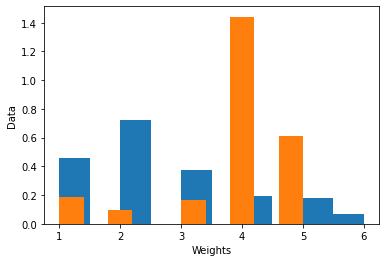

In [ ]:
plt.hist(Y_gold_bert, density=True, bins=10)  # density=False would make counts
plt.hist(Y_pred_bert, density=True, bins=10)

plt.ylabel('Data')
plt.xlabel('Weights');

In [ ]:
print(classification_report(Y_gold_bert,Y_pred_bert))
print("Accuracy: %.2f"%accuracy_score(Y_gold_bert, Y_pred_bert))
cm = make_confusion_matrices(Y_gold_bert, Y_pred_bert, 1)
cm

              precision    recall  f1-score   support

           1       0.75      0.25      0.38      5955
           2       0.38      0.04      0.07      9461
           3       0.24      0.08      0.12      4926
           4       0.11      0.64      0.19      2571
           5       0.10      0.28      0.15      2360
           6       0.00      0.00      0.00       869

    accuracy                           0.18     26142
   macro avg       0.26      0.22      0.15     26142
weighted avg       0.37      0.18      0.17     26142

Accuracy: 0.18


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1491,  182,  362, 2755, 1165,    0],
       [ 349,  374,  603, 5683, 2452,    0],
       [  69,  152,  404, 3054, 1247,    0],
       [  26,   99,  192, 1650,  604,    0],
       [  33,  125,  109, 1434,  659,    0],
       [  12,   50,   42,  498,  267,    0]])

# 7. Train BERT embeddings the Word Importance and Predict with Selected Classifier

Embeddings of more than 11,000 tokens(generated using BERT) along their corresponding importance weights have been stored in `Data.csv` file.
![Screen%20Shot%202021-12-08%20at%209.56.43%20AM.png](attachment:Screen%20Shot%202021-12-08%20at%209.56.43%20AM.png)

In [33]:
def load_data():
    X = np.loadtxt("Data.csv", delimiter=",")
    return X


In [34]:
def scale_data(y_data):
    y_all =[]
    for y in y_data:
        if 0 <= float(y) < 0.1:
            y_all.append(1);
        elif 0.1 <=  float(y) < 0.3:
            y_all.append(2);
        elif 0.3 <= float(y) < 0.5:
            y_all.append(3);
        elif 0.5 <= float(y) < 0.7:
            y_all.append(4);
        elif 0.7 <=  float(y) < 0.9:
            y_all.append(5);
        else:
            y_all.append(6);
    y_all = np.array(y_all)
    return y_all

In [35]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB


In [36]:
X = load_data()
X_data = X[:,:-1]
y_data = X[:,-1]
y_data = scale_data(y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, random_state=42)

In [37]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 7.1 Model Selection

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
print(entries)

# 7.2 Predict with Logistic Regression Classifier

In [38]:
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

Mean Absolute Error: 0.49556737588652483
Mean Squared Error: 0.8643617021276596
Root Mean Squared Error: 0.9297105474972626
              precision    recall  f1-score   support

           1       0.69      0.72      0.71       464
           2       0.64      0.68      0.66       453
           3       0.48      0.38      0.42       145
           4       0.48      0.33      0.39        39
           5       0.40      0.29      0.33        21
           6       0.56      0.83      0.67         6

    accuracy                           0.64      1128
   macro avg       0.54      0.54      0.53      1128
weighted avg       0.63      0.64      0.63      1128



array([[336, 100,  21,   4,   3,   0],
       [105, 307,  29,   7,   2,   3],
       [ 28,  56,  55,   3,   3,   0],
       [ 10,  11,   3,  13,   1,   1],
       [  5,   5,   5,   0,   6,   0],
       [  0,   0,   1,   0,   0,   5]])

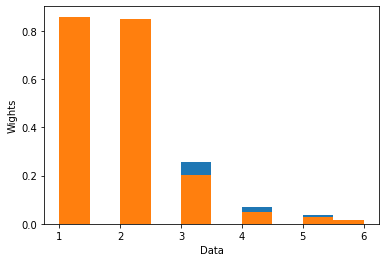

In [ ]:
plt.hist(y_test, density=True, bins=10)  # density=False would make counts
plt.hist(y_pred, density=True, bins=10)  # density=False would make counts

plt.ylabel('Wights')
plt.xlabel('Data');

# Neural Network-based Classifier: Multi-layer Perception
In thsection we will attempt to implement several neural network based approach to observe how the performance of the algorithm get changed while predicting the importance of the words. The algorithm we tried with Multi-layer Perception (MLP).

In [40]:
from sklearn.neural_network import MLPClassifier
# With Hidden layer Size 15 its performs better than other importance approach
for layers in range(15,20):
  for iterations in (300, 500,700,900,1000,1200, 1500):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(layers, ), random_state=1,  max_iter=iterations)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    y_pred
    print(classification_report(y_test,y_pred))



KeyboardInterrupt: ignored

In [ ]:
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
y_pred
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm


Mean Absolute Error: 0.43351063829787234
Mean Squared Error: 0.7703900709219859
Root Mean Squared Error: 0.8777186741331108
              precision    recall  f1-score   support

           1       0.75      0.75      0.75       464
           2       0.69      0.74      0.71       453
           3       0.55      0.49      0.52       145
           4       0.49      0.46      0.47        39
           5       0.40      0.29      0.33        21
           6       1.00      0.33      0.50         6

    accuracy                           0.69      1128
   macro avg       0.65      0.51      0.55      1128
weighted avg       0.69      0.69      0.69      1128



array([[350,  89,  17,   6,   2,   0],
       [ 78, 333,  32,   8,   2,   0],
       [ 28,  38,  71,   4,   4,   0],
       [  5,  13,   2,  18,   1,   0],
       [  4,   5,   5,   1,   6,   0],
       [  1,   2,   1,   0,   0,   2]])

# **Model** Selection while tuning hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

mlp_gs = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10,18),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10, 18), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [ ]:
print('Best parameters found:\n', clf.best_params_)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
y_pred
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

Mean Absolute Error: 0.4095744680851064
Mean Squared Error: 0.7624113475177305
Root Mean Squared Error: 0.8731616960894073
              precision    recall  f1-score   support

           1       0.73      0.80      0.76       464
           2       0.74      0.73      0.74       453
           3       0.62      0.54      0.58       145
           4       0.63      0.44      0.52        39
           5       0.59      0.48      0.53        21
           6       0.60      0.50      0.55         6

    accuracy                           0.72      1128
   macro avg       0.65      0.58      0.61      1128
weighted avg       0.71      0.72      0.71      1128



array([[370,  70,  19,   4,   1,   0],
       [ 88, 331,  24,   4,   4,   2],
       [ 31,  32,  79,   1,   2,   0],
       [ 13,   6,   3,  17,   0,   0],
       [  4,   4,   2,   1,  10,   0],
       [  0,   3,   0,   0,   0,   3]])

# Neural Network-based Classifier: Multi-layer Perceptron Regressor
Here is another approach, we attempted titled as: **Multi-layer Perceptron Regressor**.

In [41]:
from sklearn.neural_network import MLPRegressor

In [42]:
regr = MLPRegressor(random_state=1, max_iter=500, solver = 'adam').fit(X_train, y_train)

In [43]:
y_pred = regr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


y_round_pred = np.round_(y_pred, decimals = 0)
y_round_pred
# y_test
print(classification_report(y_test,y_round_pred))
cm = make_confusion_matrices(y_test, y_round_pred, 1)
cm


Mean Absolute Error: 0.5892641180388437
Mean Squared Error: 0.6468148941903107
Root Mean Squared Error: 0.8042480302682193
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
        -0.0       0.00      0.00      0.00         0
         1.0       0.69      0.59      0.64       464
         2.0       0.55      0.59      0.57       453
         3.0       0.31      0.36      0.33       145
         4.0       0.09      0.08      0.08        39
         5.0       0.50      0.10      0.16        21
         6.0       1.00      0.33      0.50         6

    accuracy                           0.53      1128
   macro avg       0.39      0.26      0.29      1128
weighted avg       0.56      0.53      0.54      1128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  24, 275, 143,  19,   0,   0,   0],
       [  0,   4, 103, 269,  71,   5,   1,   0],
       [  0,   1,  16,  61,  52,  15,   0,   0],
       [  0,   0,   2,  13,  21,   3,   0,   0],
       [  0,   0,   0,   4,   6,   9,   2,   0],
       [  0,   0,   0,   2,   0,   1,   1,   2]])

# Performance Comparison across Keyword extraction method in identifying weights of words in comparison with human annotators (Explainability)

# Method: *KeyBERT*

In [ ]:
!pip3 install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 31.8 MB/s 
     |████████████████████████████████| 749 kB 57.8 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def get_sentence_list(file_name):
    files = open(file_name)
    sentence_set=[]
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        sentence_set.append(actual_sentence.replace("\n",""))
    return sentence_set

In [ ]:
from rake_nltk import Rake
r = Rake()
WRake_MSE = 0
WRake_Accuracy = []
Y_gold_rake = [] 
Y_pred_rake = []
# my_text = """
# When it comes to evaluating the performance of keyword extractors, you can use some of the standard metrics in machine learning: accuracy, precision, recall, and F1 score. However, these metrics don’t reflect partial matches; they only consider the perfect match between an extracted segment and the correct prediction for that tag.
# Fortunately, there are some other metrics capable of capturing partial matches. An example of this is ROUGE.
# """
final_score = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            scores = get_wimp_scores(wimp_file)
            # print(scores)
            corpus = get_sentence_list(file)
            word_score = []
            
            for sentence in corpus:
              
              r.extract_keywords_from_text(sentence)
              rankedList  = r.get_ranked_phrases_with_scores()

              sentence_score = []
              wordList = get_words_list_from_sentence(sentence)
              
              for keyword in rankedList:
                keywords = keyword[1].split()
                # print(keyword[0]/10, " ", keywords)
                for keywd in keywords:
                  if keywd in wordList:
                    indx = wordList.index(keywd)
                    wordList[indx] = keyword[0]/10
                
              
              word_score.append([word_imp_score if isinstance(word_imp_score, float) else 0 for word_imp_score in wordList ])
             
            
            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(word_score[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_rake += make_scalar(scores[i], 0)
                    Y_pred_rake += make_scalar(word_score[i], 0)
                    for j in range(0,len(scores[i])):
                        if compare(float(word_score[i][j]), float(scores[i][j])):
                            correct = correct +1
                            WRake_MSE = WRake_MSE + pow((float(word_score[i][j])-float(scores[i][j])),2)

            accuracy = correct/total
            WRake_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(WRake_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("MSE: ", str(WRake_MSE))

            
              

Document Processed- 1/44: Accuracy 0.23
Document Processed- 2/44: Accuracy 0.19
Document Processed- 3/44: Accuracy 0.21
Document Processed- 4/44: Accuracy 0.18
Document Processed- 5/44: Accuracy 0.22
Document Processed- 6/44: Accuracy 0.22
Document Processed- 7/44: Accuracy 0.29
Document Processed- 8/44: Accuracy 0.21
Document Processed- 9/44: Accuracy 0.15
Document Processed- 10/44: Accuracy 0.20
Document Processed- 11/44: Accuracy 0.27
Document Processed- 12/44: Accuracy 0.19
Document Processed- 13/44: Accuracy 0.18
Document Processed- 14/44: Accuracy 0.25
Document Processed- 15/44: Accuracy 0.30
Document Processed- 16/44: Accuracy 0.21
Document Processed- 17/44: Accuracy 0.22
Document Processed- 18/44: Accuracy 0.23
Document Processed- 19/44: Accuracy 0.19
Document Processed- 20/44: Accuracy 0.21
Document Processed- 21/44: Accuracy 0.22
Document Processed- 22/44: Accuracy 0.15
Document Processed- 23/44: Accuracy 0.27
Document Processed- 24/44: Accuracy 0.22
Document Processed- 25/44

In [ ]:
print(classification_report(Y_gold_rake,Y_pred_rake))
print("Accuracy: %.2f"%accuracy_score(Y_gold_rake,Y_pred_rake))
cm = make_confusion_matrices(Y_gold_rake,Y_pred_rake, 1)
cm

              precision    recall  f1-score   support

           1       0.27      0.72      0.39      5829
           2       0.16      0.08      0.11      9185
           3       0.20      0.13      0.16      4828
           4       0.12      0.00      0.00      2510
           5       0.18      0.02      0.04      2301
           6       0.07      0.14      0.09       844

    accuracy                           0.23     25497
   macro avg       0.17      0.18      0.13     25497
weighted avg       0.19      0.23      0.17     25497

Accuracy: 0.23


array([[4189,  888,  396,   11,   63,  282],
       [7622,  757,  474,    5,   48,  279],
       [2617, 1197,  608,    3,   68,  335],
       [ 239, 1161,  669,    4,   65,  372],
       [ 405,  731,  618,   10,   57,  480],
       [ 346,  144,  209,    1,   22,  122]])

# NLTK-Rake Investigation

In [ ]:
!pip3 install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.9 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.5.1-py3-none-any.whl size=21332 sha256=40b368c2594acfd6c0f481ab444e9de3cb91d7bb06e7e2daa2000be595556466
  Stored in directory: /root/.cache/pip/wheels/8e/95/c5/f5ceed2a9f9e80bc1a706a10a6fb03d726df7a3dd11800a58b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=e6983e363bb2d0073f9724947e1db59d06b318b3082e47a02ff37d9456fb251b
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b68

In [ ]:
from keybert import KeyBERT
doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs. It infers a
         function from labeled training data consisting of a set of training examples.
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias)."""
kw_model = KeyBERT()


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
keywords = kw_model.extract_keywords(doc)
print(keywords[0][0], keywords[0][1])

supervised 0.6676


In [ ]:
WKBert_MSE = 0
WKBert_Accuracy = []
Y_gold_KBert = [] 
Y_pred_KBert = []
# my_text = """
# When it comes to evaluating the performance of keyword extractors, you can use some of the standard metrics in machine learning: accuracy, precision, recall, and F1 score. However, these metrics don’t reflect partial matches; they only consider the perfect match between an extracted segment and the correct prediction for that tag.
# Fortunately, there are some other metrics capable of capturing partial matches. An example of this is ROUGE.
# """
final_score = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            scores = get_wimp_scores(wimp_file)
            # print(scores)
            corpus = get_sentence_list(file)
            word_score = []
            
            for sentence in corpus:
              
              keywords = kw_model.extract_keywords(sentence)

              sentence_score = []
              wordList = get_words_list_from_sentence(sentence)
              
              for keyword in keywords:
               
                  if keyword[0] in wordList:
                    indx = wordList.index(keyword[0])
                    wordList[indx] = keyword[1]
                
              
              word_score.append([word_imp_score if isinstance(word_imp_score, float) else 0 for word_imp_score in wordList ])
             
            
            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(word_score[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_KBert += make_scalar(scores[i], 0)
                    Y_pred_KBert += make_scalar(word_score[i], 0)
                    for j in range(0,len(scores[i])):
                        if compare(float(word_score[i][j]), float(scores[i][j])):
                            correct = correct +1
                            WKBert_MSE = WKBert_MSE + pow((float(word_score[i][j])-float(scores[i][j])),2)

            accuracy = correct/total
            WKBert_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(WKBert_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("MSE: ", str(WKBert_MSE))

Document Processed- 1/44: Accuracy 0.25
Document Processed- 2/44: Accuracy 0.20
Document Processed- 3/44: Accuracy 0.21
Document Processed- 4/44: Accuracy 0.18
Document Processed- 5/44: Accuracy 0.21
Document Processed- 6/44: Accuracy 0.23
Document Processed- 7/44: Accuracy 0.25
Document Processed- 8/44: Accuracy 0.21
Document Processed- 9/44: Accuracy 0.18
Document Processed- 10/44: Accuracy 0.21
Document Processed- 11/44: Accuracy 0.31
Document Processed- 12/44: Accuracy 0.19
Document Processed- 13/44: Accuracy 0.19
Document Processed- 14/44: Accuracy 0.26
Document Processed- 15/44: Accuracy 0.26
Document Processed- 16/44: Accuracy 0.22
Document Processed- 17/44: Accuracy 0.22
Document Processed- 18/44: Accuracy 0.22
Document Processed- 19/44: Accuracy 0.21
Document Processed- 20/44: Accuracy 0.24
Document Processed- 21/44: Accuracy 0.22
Document Processed- 22/44: Accuracy 0.14
Document Processed- 23/44: Accuracy 0.27
Document Processed- 24/44: Accuracy 0.22
Document Processed- 25/44

In [ ]:
print(classification_report(Y_gold_KBert,Y_pred_KBert))
print("Accuracy: %.2f"%accuracy_score(Y_gold_KBert,Y_pred_KBert))
cm = make_confusion_matrices(Y_gold_KBert,Y_pred_KBert, 1)
cm

              precision    recall  f1-score   support

           1       0.25      0.90      0.40      5829
           2       0.15      0.04      0.06      9185
           3       0.09      0.03      0.05      4828
           4       0.26      0.06      0.09      2510
           5       0.15      0.01      0.01      2301
           6       0.00      0.00      0.00       844

    accuracy                           0.23     25497
   macro avg       0.15      0.17      0.10     25497
weighted avg       0.17      0.23      0.13     25497

Accuracy: 0.23


array([[5252,  290,   99,   42,   33,  113],
       [8582,  340,   88,   34,   23,  118],
       [4128,  449,  161,   45,   17,   28],
       [1257,  654,  443,  142,   14,    0],
       [ 941,  403,  722,  211,   18,    6],
       [ 454,   90,  212,   74,   14,    0]])

In [ ]:
WKBert_MSE = 0
WKBert_Accuracy = []
Y_gold_KBert = [] 
Y_pred_KBert = []
# my_text = """
# When it comes to evaluating the performance of keyword extractors, you can use some of the standard metrics in machine learning: accuracy, precision, recall, and F1 score. However, these metrics don’t reflect partial matches; they only consider the perfect match between an extracted segment and the correct prediction for that tag.
# Fortunately, there are some other metrics capable of capturing partial matches. An example of this is ROUGE.
# """
final_score = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            f1 = open(file, 'r')
            keywords = kw_model.extract_keywords(f1.read())
            print(keywords)
            # scores = get_wimp_scores(wimp_file)
            # # print(scores)
            # corpus = get_sentence_list(file)

            # word_score = []
            
            # for sentence in corpus:
              
            #   keywords = kw_model.extract_keywords(sentence)

            #   sentence_score = []
            #   wordList = get_words_list_from_sentence(sentence)
              
            #   for keyword in keywords:
               
            #       if keyword[0] in wordList:
            #         indx = wordList.index(keyword[0])
            #         wordList[indx] = keyword[1]
                
              
            #   word_score.append([word_imp_score if isinstance(word_imp_score, float) else 0 for word_imp_score in wordList ])
             
            
            # total = 0 
            # correct = 0
            # for i in range(0,len(scores)):

            #     if len(word_score[i]) == len(scores[i]):
            #         total = total + len(scores[i])
            #         Y_gold_KBert += make_scalar(scores[i], 0)
            #         Y_pred_KBert += make_scalar(word_score[i], 0)
            #         for j in range(0,len(scores[i])):
            #             if compare(float(word_score[i][j]), float(scores[i][j])):
            #                 correct = correct +1
            #                 WKBert_MSE = WKBert_MSE + pow((float(word_score[i][j])-float(scores[i][j])),2)

            # accuracy = correct/total
            # WKBert_Accuracy.append(accuracy)
            # print("Document Processed- "+str(len(WKBert_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("MSE: ", str(WKBert_MSE))

[('silence', 0.3426), ('elderly', 0.3071), ('0059', 0.3032), ('0048', 0.2947), ('grandparents', 0.2929)]
[('silence', 0.3248), ('married', 0.3168), ('activity', 0.3052), ('sound', 0.3041), ('laughter', 0.3011)]
[('bengals', 0.5585), ('49ers', 0.4174), ('raiders', 0.4068), ('teams', 0.3702), ('team', 0.3349)]
[('expenses', 0.4232), ('savings', 0.398), ('spend', 0.3735), ('spendable', 0.3432), ('budget', 0.3228)]
[('weather', 0.4082), ('dallas', 0.3627), ('sw2450a', 0.3429), ('noise', 0.326), ('warm', 0.3111)]
[('noise', 0.4183), ('silence', 0.3681), ('vocalized', 0.332), ('moon', 0.316), ('laughter', 0.3119)]
[('sw2636a', 0.452), ('silence', 0.4088), ('264', 0.3224), ('ms98', 0.3146), ('0026', 0.3007)]
[('credit', 0.405), ('cards', 0.3424), ('pin', 0.3212), ('card', 0.3198), ('cash', 0.302)]
[('silence', 0.3299), ('noise', 0.3251), ('interrupt', 0.3176), ('reading', 0.3074), ('reader', 0.2933)]
[('fertilizer', 0.5666), ('lawns', 0.4535), ('lawn', 0.4433), ('fertilize', 0.4172), ('grass'

# AutoEncoder Feature Extraction

https://machinelearningmastery.com/autoencoder-for-classification/

768
Epoch 1/200
635/635 - 41s - loss: 0.0333 - val_loss: 0.0221 - 41s/epoch - 65ms/step
Epoch 2/200
635/635 - 32s - loss: 0.0162 - val_loss: 0.0131 - 32s/epoch - 51ms/step
Epoch 3/200
635/635 - 32s - loss: 0.0127 - val_loss: 0.0115 - 32s/epoch - 51ms/step
Epoch 4/200
635/635 - 41s - loss: 0.0112 - val_loss: 0.0163 - 41s/epoch - 65ms/step
Epoch 5/200
635/635 - 36s - loss: 0.0103 - val_loss: 0.0106 - 36s/epoch - 56ms/step
Epoch 6/200
635/635 - 36s - loss: 0.0092 - val_loss: 0.0111 - 36s/epoch - 56ms/step
Epoch 7/200
635/635 - 28s - loss: 0.0088 - val_loss: 0.0086 - 28s/epoch - 45ms/step
Epoch 8/200
635/635 - 29s - loss: 0.0084 - val_loss: 0.0079 - 29s/epoch - 45ms/step
Epoch 9/200
635/635 - 41s - loss: 0.0079 - val_loss: 0.0263 - 41s/epoch - 65ms/step
Epoch 10/200
635/635 - 46s - loss: 0.0080 - val_loss: 0.0077 - 46s/epoch - 72ms/step
Epoch 11/200
635/635 - 42s - loss: 0.0069 - val_loss: 0.0073 - 42s/epoch - 67ms/step
Epoch 12/200
635/635 - 36s - loss: 0.0067 - val_loss: 0.0055 - 36s/epo

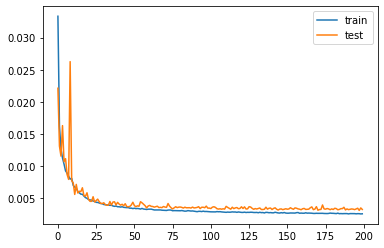

In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# number of input columns
n_inputs = X_data.shape[1]
print(n_inputs)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [ ]:
# evaluate logistic regression on encoded input
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.5966312056737588


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(classification_report(y_test,yhat))
print("Accuracy: %.2f"%accuracy_score(y_test,yhat))
cm = make_confusion_matrices(y_test,yhat, 1)
cm

              precision    recall  f1-score   support

           1       0.66      0.72      0.69       464
           2       0.58      0.64      0.61       453
           3       0.37      0.23      0.28       145
           4       0.48      0.26      0.33        39
           5       0.45      0.24      0.31        21
           6       0.75      0.50      0.60         6

    accuracy                           0.60      1128
   macro avg       0.55      0.43      0.47      1128
weighted avg       0.58      0.60      0.58      1128

Accuracy: 0.60


array([[332, 107,  21,   3,   1,   0],
       [122, 290,  34,   2,   5,   0],
       [ 28,  80,  33,   4,   0,   0],
       [ 14,  14,   0,  10,   0,   1],
       [  7,   5,   2,   2,   5,   0],
       [  0,   3,   0,   0,   0,   3]])

# Identification of Important Words within Dataset using POS-TAG

In [44]:
high_important_words = {'start'}
low_important_words = {'start'}
POS_Important = []
POS_Low_Important = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            scores = get_wimp_scores(wimp_file)
            # print(scores)
            corpus = get_sentence_list(file)
            # word_score = []
            sentence_id = 0
            for sentence in corpus:
              sentence_score = []
              wordList = get_words_list_from_sentence(sentence)
              
              if len(wordList) == len(scores[sentence_id]):
                wordPos = pos_tag(wordList)
                
                # print(wordPos)
                for i in range(0, len(wordList)):
                  # print(wordList[i])
                  # print("Pos:", wordPos[i])
                  if float(scores[sentence_id][i]) >= 0.8:
                    high_important_words.add(wordList[i])
                    POS_Important.append(wordPos[i][1])
                  elif float(scores[sentence_id][i]) <= 0.1:
                    low_important_words.add(wordList[i])
                    POS_Low_Important.append(wordPos[i][1])
              sentence_id = sentence_id + 1
print(high_important_words)
print(POS_Important)
print(low_important_words)
print(POS_Low_Important)


{'half', 'hit', 'zero', 'boat', 'great', 'minute', '[laughter-Roses]', 'mom', 'conditioner', 'people', 'lieutenant', 'not', 'opinion', 'tax', 'economic', 'The', 'relatives', 'store', 'Craftsman', 'blues', 'Worth', 'coats', 'York', 'Rolling', 'Foreigner', 'artificial', 'sleds', 'participation', 'bye', 'movies', 'Chrysler', 'little', 'Girl', 'Legacy', 'cylinder', 'day', 'hometown', 'museum', 'storm', 'Pinball', 'Union', 'warnings', 'suburban', 'walking', 'apartments', 'Lee', 'okay', 'scattered', 'false', "[laughter-haven't]", 'story', 'comfortable', 'lifting', 'flowers', 'project', 'sharing', 'years', 'weekend', 'abuse', 'property', 'happen', 'killing', 'how-to', 'department', 'positive', 'season', 'running', 'streets', 'five', 'Sox', 'fat', 'manufacturers', 'keys', 'empire', 'funds', 'skate', 'family', '[laughter-drugs]', 'instruments', 'World', 'Brave', 'Communist', 'trade', 'Moon', 'jewelry', 'condition', 'Europe', 'MasterCard', 'love', 'bottle', 'Auel', 'Christmas', 'samples', 'pumps

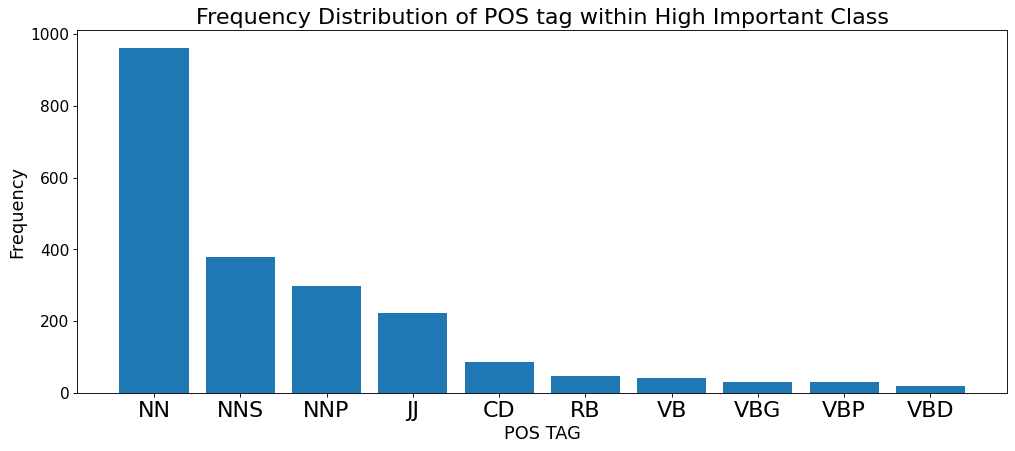

In [45]:
from collections import Counter
from matplotlib.pyplot import figure

counts = Counter(POS_Important)

# counts = counts.most_common(10)
new_counts = counts.most_common(10)
keys = []
values = []
for key, value in new_counts:
  keys.append(key)
  values.append(value)

figure(figsize = (15, 6), dpi = 80)

# plt.bar(counts.keys(), counts.values())
plt.bar(keys,values)
plt.xlabel('POS TAG', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title("Frequency Distribution of POS tag within High Important Class", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.show()


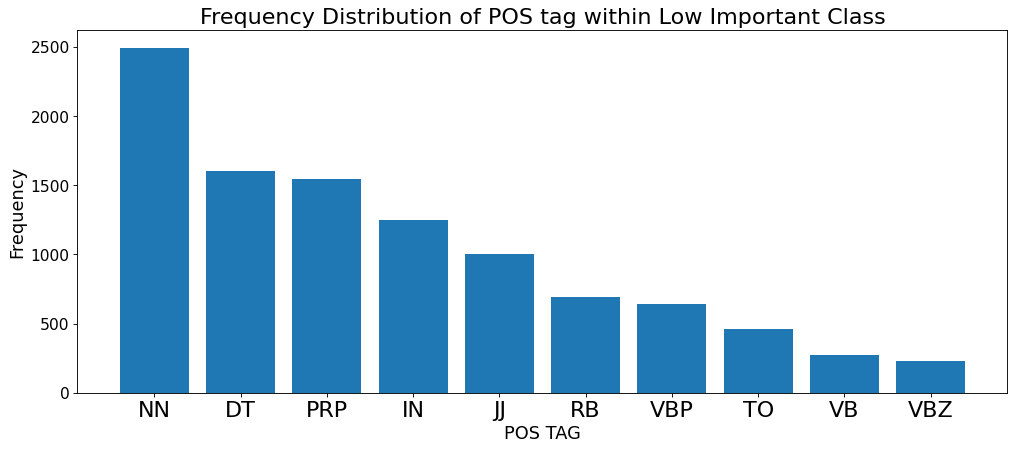

In [46]:
from collections import Counter


countsLow = Counter(POS_Low_Important)

# counts = counts.most_common(10)
new_counts = countsLow.most_common(10)
keys = []
values = []
for key, value in new_counts:
  keys.append(key)
  values.append(value)

figure(figsize = (15, 6), dpi = 80)

# plt.bar(counts.keys(), counts.values())
plt.bar(keys,values)
plt.xlabel('POS TAG', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title("Frequency Distribution of POS tag within Low Important Class", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=14)
plt.show()


In [56]:
import re
import pandas as pd


corpus_full_sent = []
corpus_full_score = []
word_bert_embedding_full = []
pos_importance = []
unmatched_sentence = []
word_pos_map = []

for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            scores = get_wimp_scores(wimp_file)
            # print(scores)
            corpus = get_sentence_list(file)
            # word_score = []
            sentence_id = 0
            for sentence in corpus:
              # sentence =  re.sub(r'[^a-zA-Z0-9]', ' ', sentence)
              sentence_mat, tokenized_text = BERT_Embedding(sentence)
              sentence_token_map = []

              print(len(sentence_mat[1:-1]), len(scores[sentence_id]))

              if len(sentence_mat[1:-1]) == len(scores[sentence_id]):
                corpus_full_sent.append(sentence)
                corpus_full_score = corpus_full_score + scores[sentence_id]
                wordPosTag = pos_tag(tokenized_text)
                word_pos_map.append(wordPosTag)
                
                for posTag in wordPosTag[1:-1]:
                  pos_importance.append(posTag[1])

                # print("token:: ",len(tokenized_text))
                # print("actual:: ", len(scores[sentence_id]))
                # print("tag length:", len(wordPosTag))

                index = 1
                count = 1

                for word_emb in sentence_mat[1:-1]:
                    
                    word_emb = np.reshape(word_emb,(word_emb.size,1))
                  
                    word_bert_embedding_full.append(word_emb)

                    count = 1
                  
                    index = index + 1
              else:
                  unmatched_sentence.append({'text': sentence,  'score':scores[sentence_id]})
                  
              sentence_id = sentence_id + 1

dataFormatted = pd.DataFrame(unmatched_sentence, columns=['text', 'score'])
dataFormatted.to_excel('unmatched_sentence_data.xlsx')

# print(len(corpus_full_sent))
# print(len(corpus_full_score))



32 28
3 1
2 2
3 1
3 1
3 1
1 1
3 1
1 1
3 1
1 1
3 1
42 40
42 36
16 16
52 47
31 29
17 17
39 37
30 30
46 46
29 29
43 43
56 51
3 1
6 6
3 1
3 1
3 1
1 1
3 1
3 1
3 1
25 25
3 1
31 31
15 15
18 16
59 48
2 2
29 21
25 23
33 33
27 22
3 1
1 1
1 1
3 1
24 20
20 20
41 34
36 30
1 1
3 1
12 12
47 37
68 30
3 1
38 32
27 21
29 27
40 34
48 43
17 10
3 1
2 2
1 1
3 1
2 2
8 6
3 1
7 5
3 1
3 1
15 15
30 24
19 17
3 1
2 2
3 1
3 1
3 1
3 1
9 7
3 1
3 1
3 1
5 3
3 1
3 1
19 17
3 1
3 1
3 1
3 1
3 1
3 1
3 3
3 1
3 1
3 1
3 1
3 1
1 1
3 1
3 1
10 6
3 1
1 1
3 1
5 3
10 4
3 1
23 17
8 6
50 42
37 35
23 19
34 30
23 23
37 33
18 16
12 12
3 1
3 1
3 1
3 1
3 1
5 3
3 1
3 1
3 1
1 1
3 3
19 15
21 21
10 7
33 30
3 1
9 7
21 17
16 14
1 1
3 1
26 24
30 22
3 1
3 1
3 1
15 13
3 1
1 1
1 1
21 17
3 1
5 5
3 1
20 17
3 1
6 6
3 1
1 1
3 1
15 13
3 1
29 27
10 10
17 9
3 1
1 1
11 7
3 1
1 1
3 1
10 10
3 1
7 7
3 1
2 2
3 1
4 4
3 1
5 3
3 1
30 23
3 1
11 9
3 1
1 1
3 1
7 5
51 36
3 1
8 6
3 1
1 1
3 1
33 29
11 11
12 11
17 17
44 43
32 26
18 18
24 24
43 34
3 1
13 13
1 1
47 45
47 4

In [49]:
np_corpus_score = np.asarray(word_bert_embedding_full)
# np_corpus_score = np.expand_dims(np_corpus_score, axis=1)
np_corpus_score = np_corpus_score.mean(axis=2)
np_corpus_score.shape

(5363, 768)

In [50]:
from nltk.data import load
nltk.download('tagsets')
tagdict = load('help/tagsets/upenn_tagset.pickle')
tags = []
final_pos_importance = []
for key in tagdict.keys():
  tags.append(key)


for POS_tag in pos_importance:
  try:
    if tags.index(POS_tag):
      indx = tags.index(POS_tag)+1
      final_pos_importance.append(indx)
  except:
    final_pos_importance.append(-1)

np_wordPosTag = np.asarray(final_pos_importance)
np_PosTag= np.expand_dims(np_wordPosTag, axis=1)
np_PosTag.shape


[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


(5363, 1)

In [51]:
np_corpus_full_score = np.asarray(corpus_full_score)
np_wimpscore= np.expand_dims(np_corpus_full_score, axis=1)
np_wimpscore.shape

(5363, 1)

In [52]:
X_Total = np.hstack((np_corpus_score,np_PosTag,np_wimpscore))
X_Total.shape

(5363, 770)

In [55]:
import pandas as pd 
pd.DataFrame(X_Total).to_csv("POSAugmentedData.csv")

In [61]:
word_pos = np.array(word_pos_map)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [62]:
import pandas as pd 
pd.DataFrame(word_pos).to_csv("SentenceTokenPOSData.csv")

In [63]:
X_data = X_Total[:,:-1]
y_data = X_Total[:,-1]
y_data = scale_data(y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, random_state=42)

In [64]:
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

Mean Absolute Error: 0.4860335195530726
Mean Squared Error: 0.7132216014897579
Root Mean Squared Error: 0.8445244824691336
              precision    recall  f1-score   support

           1       0.75      0.74      0.74        99
           2       0.67      0.71      0.69       200
           3       0.37      0.34      0.36       108
           4       0.41      0.42      0.41        57
           5       0.63      0.64      0.64        53
           6       0.80      0.60      0.69        20

    accuracy                           0.60       537
   macro avg       0.60      0.58      0.59       537
weighted avg       0.60      0.60      0.60       537



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


array([[ 73,  20,   4,   1,   1,   0],
       [ 14, 142,  41,   2,   1,   0],
       [  6,  45,  37,  15,   5,   0],
       [  3,   5,  15,  24,  10,   0],
       [  0,   0,   2,  14,  34,   3],
       [  1,   0,   1,   3,   3,  12]])

In [ ]:
from sklearn.model_selection import GridSearchCV

mlp_gs = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10,18),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10, 18), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [ ]:
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
y_pred
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Mean Absolute Error: 0.4227188081936685
Mean Squared Error: 0.6163873370577281
Root Mean Squared Error: 0.7851033925908919
              precision    recall  f1-score   support

           1       0.85      0.74      0.79        99
           2       0.69      0.79      0.74       200
           3       0.51      0.44      0.47       108
           4       0.41      0.51      0.46        57
           5       0.70      0.62      0.66        53
           6       0.73      0.55      0.63        20

    accuracy                           0.65       537
   macro avg       0.65      0.61      0.62       537
weighted avg       0.66      0.65      0.65       537



array([[ 73,  21,   4,   0,   1,   0],
       [  9, 157,  29,   5,   0,   0],
       [  1,  40,  47,  18,   2,   0],
       [  2,   8,  10,  29,   8,   0],
       [  0,   1,   2,  13,  33,   4],
       [  1,   0,   0,   5,   3,  11]])

# Data Augmentation using Masking
bert-large-cased-whole-word-masking: https://huggingface.co/bert-large-cased-whole-word-masking

---



```@article{DBLP:journals/corr/abs-1810-04805,
  author    = {Jacob Devlin and
               Ming{-}Wei Chang and
               Kenton Lee and
               Kristina Toutanova},
  title     = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language
               Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}```

In [65]:
masked_sentences = []
masked_sentence_score = []

for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            scores = get_wimp_scores(wimp_file)
            # print(scores)
            corpus = get_sentence_list(file)
            # word_score = []
            sentence_id = 0
            masked_count = 0
            for sentence in corpus:
              sentence_score = []
              wordList = get_words_list_from_sentence(sentence)
              # This condition has been incorporated to give BERT more context to produce more sample text out of the 
              if len(wordList) == len(scores[sentence_id]) and len(wordList)<=15 and len(wordList)>=5:
                
                
                # print(wordPos)
                for i in range(0, len(wordList)):
                  # print(wordList[i])
                  # print("Pos:", wordPos[i])
                  if float(scores[sentence_id][i]) >= 0.8:
                    # high_important_words.add(wordList[i])
                    wordList[i] = "[MASK]"
                    masked_count = masked_count + 1
                if masked_count==1:
                  sentence_reconstructed = ' '.join(wordList)
                  masked_sentences.append(sentence_reconstructed)
                  masked_sentence_score.append(scores[sentence_id])
                  masked_count = 0
              sentence_id = sentence_id + 1
print(masked_sentences)
print(masked_sentence_score)

['yeah yeah i i i think that perhaps perhaps the extended [MASK]', 'well i uh before i was married i used to play a lot of [MASK]', 'you know like a [MASK] or [laughter]', 'so what kind of weather have you had in [MASK] [laughter]', 's[ame]- same type yeah same type of [MASK] it was just uh different location', "and that's that's how a lot of [MASK] get into trouble", 'yeah well you have a lot of [MASK] i uh', "because_1 i have one that i don't have a [MASK] number for", 'and then i have one that uh just gave me the [MASK] number automatically', "he's a [MASK] man too so [laughter]", 'okay so uh what do you do with your [MASK]', 'uh-huh do you put any [MASK] or anything like that', 'and how about_1 uh like [MASK] or the you know bushes or flowers or anything', "and by doing that i guess it sort of acts like it's own [MASK]", "oh you mean so that's a separate [MASK]", "oh i'll have to look for that i didn't know it was a separate [MASK]", '[MASK] well it was very nice talking to you', '

In [66]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-large-cased-whole-word-masking')

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [73]:
import re

corpus_sent = []
corpus_score = []
word_bert_embedding = []
pos_importance = []

masked_text_score = []

for i in range(0, len(masked_sentences)):
  generated_corpus = unmasker(masked_sentences[i])
  
  for sentence in generated_corpus:
    sentence_new = sentence['sequence']

    


    sentence_new =  re.sub(r'[^a-zA-Z0-9]', ' ', sentence_new)
    print(sentence_new)

    sentence_mat, tokenized_text = BERT_Embedding(sentence_new)


    sentence_token_map = []

    
    masked_text_score.append((sentence_new,masked_sentence_score[i]))
    if len(tokenized_text) - len(masked_sentence_score[i]) == 2:

      # print(tokenized_text[1:-1])
      # print(masked_sentence_score[i])
      

      corpus_sent.append(sentence_new)
      corpus_score = corpus_score + masked_sentence_score[i]
      print("token:: ",len(tokenized_text))
      print("actual:: ", len(masked_sentence_score[i]))
      index = 1
      count = 1

      wordPosTag = pos_tag(tokenized_text)
                
      for posTag in wordPosTag[1:-1]:
        pos_importance.append(posTag[1])

      for word_emb in sentence_mat[1:-1]:
          
          word_emb = np.reshape(word_emb,(word_emb.size,1))
         
          word_bert_embedding.append(word_emb)

          count = 1
        
          index = index + 1

print(corpus_sent)
print(corpus_score)

yeah yeah i i i think that perhaps perhaps the extended version
token::  14
actual::  12
yeah yeah i i i think that perhaps perhaps the extended family
token::  14
actual::  12
yeah yeah i i i think that perhaps perhaps the extended 
yeah yeah i i i think that perhaps perhaps the extended band
token::  14
actual::  12
yeah yeah i i i think that perhaps perhaps the extended period
token::  14
actual::  12
well i uh before i was married i used to play a lot of games
token::  17
actual::  15
well i uh before i was married i used to play a lot of sports
token::  17
actual::  15
well i uh before i was married i used to play a lot of tennis
token::  17
actual::  15
well i uh before i was married i used to play a lot of music
token::  17
actual::  15
well i uh before i was married i used to play a lot of piano
token::  17
actual::  15
you know like a dog or   laughter  
token::  9
actual::  7
you know like a man or   laughter  
token::  9
actual::  7
you know like a puppy or   laughter  
toke

In [74]:
np_masked_text_score = np.array(masked_text_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [75]:
import pandas as pd 
pd.DataFrame(np_masked_text_score).to_csv("MaskedSentenceWithImportanceTag.csv")

In [76]:
from nltk.data import load
nltk.download('tagsets')
tagdict = load('help/tagsets/upenn_tagset.pickle')
tags = []
final_pos_importance = []
for key in tagdict.keys():
  tags.append(key)


for POS_tag in pos_importance:
  try:
    if tags.index(POS_tag):
      indx = tags.index(POS_tag)+1
      final_pos_importance.append(indx)
  except:
    final_pos_importance.append(-1)

np_wordPosTag = np.asarray(final_pos_importance)
np_PosTag= np.expand_dims(np_wordPosTag, axis=1)
np_PosTag.shape

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


(1296, 1)

In [77]:
np_corpus_score = np.asarray(corpus_score)
np_corpus_score = np.expand_dims(np_corpus_score, axis=1)
np_corpus_score.shape

(1296, 1)

In [78]:
nparray_embedding = np.asarray(word_bert_embedding)
nparray_embedding = nparray_embedding.mean(axis=2)
nparray_embedding.shape

(1296, 768)

In [79]:
augmented_data = np.hstack((nparray_embedding, np_corpus_score))
# augmented_data = np.hstack((nparray_embedding, np_PosTag, np_corpus_score))

augmented_data.shape


(1296, 769)

In [85]:
X = load_data()
X = np.vstack((X,augmented_data))
X.shape
X_data = X[:,:-1]
y_data = X[:,-1]
y_data = scale_data(y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, random_state=42)

In [86]:
import pandas as pd 
pd.DataFrame(X).to_csv("MaskedAugmentedData.csv")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

mlp_gs = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10,18),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10, 18), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [ ]:
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
y_pred
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

Mean Absolute Error: 0.5457463884430177
Mean Squared Error: 1.1637239165329052
Root Mean Squared Error: 1.078760361031543
              precision    recall  f1-score   support

           1       0.75      0.67      0.71       473
           2       0.66      0.74      0.70       507
           3       0.55      0.46      0.50       164
           4       0.38      0.44      0.41        54
           5       0.37      0.38      0.37        29
           6       0.38      0.47      0.42        19

    accuracy                           0.65      1246
   macro avg       0.51      0.53      0.52      1246
weighted avg       0.66      0.65      0.65      1246



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


array([[319, 108,  22,  10,   8,   6],
       [ 67, 374,  35,  20,   8,   3],
       [ 24,  56,  76,   5,   2,   1],
       [ 10,  16,   3,  24,   0,   1],
       [  3,   6,   2,   3,  11,   4],
       [  2,   4,   1,   2,   1,   9]])

# Data Augmentation with POS tagged data

In [87]:
# augmented_data = np.hstack((nparray_embedding, np_corpus_score))
augmented_data = np.hstack((nparray_embedding, np_PosTag, np_corpus_score))

augmented_data.shape



(1296, 770)

In [88]:
X = np.vstack((X_Total,augmented_data))
X.shape

(6659, 770)

In [89]:
import pandas as pd 
pd.DataFrame(X).to_csv("MaskedPOSAugmentedData.csv")

In [ ]:

X_data = X[:,:-1]
y_data = X[:,-1]
y_data = scale_data(y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

mlp_gs = MLPClassifier(max_iter=500)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10,18),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10, 18), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [ ]:
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
y_pred
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

Mean Absolute Error: 0.33783783783783783
Mean Squared Error: 0.46096096096096095
Root Mean Squared Error: 0.6789410585323007
              precision    recall  f1-score   support

           1       0.80      0.83      0.81       145
           2       0.79      0.77      0.78       270
           3       0.56      0.56      0.56       117
           4       0.52      0.63      0.57        54
           5       0.70      0.66      0.68        61
           6       0.58      0.37      0.45        19

    accuracy                           0.71       666
   macro avg       0.66      0.64      0.64       666
weighted avg       0.72      0.71      0.71       666



array([[121,  20,   4,   0,   0,   0],
       [ 25, 208,  31,   5,   1,   0],
       [  5,  32,  65,  12,   2,   1],
       [  0,   2,  12,  34,   6,   0],
       [  1,   0,   3,  13,  40,   4],
       [  0,   0,   2,   2,   8,   7]])

# Model Interpretation
Try different metrics from here: https://ing-bank.github.io/probatus/tutorials/nb_imputation_comparison.html

In [ ]:
!pip install probatus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 22.4 MB/s 
     |████████████████████████████████| 352 kB 52.6 MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490560 sha256=630f2a38fd2982878f08a9b968fb0da33be2ae5b87022fea111a16fa1e1ac1af
  Stored in directory: /root/.cache/pip/wheels/34/33/98/2c03c2e06312e616f7a8dad3fbbcc78fc9eb1d665abcef1060
Successfully built shap


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from probatus.interpret import ShapModelInterpreter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test, approximate=False)
feature_importance

ValueError: ignored

In [ ]:
ax = shap_interpreter.plot('importance')

In [ ]:
ax = shap_interpreter.plot('summary')